In [35]:
import sys
import os

# Add the build directory to Python path
build_dir = os.path.abspath('/Users/kisel/uni/apal/Algorithm-Selector/Implementation/lib')
sys.path.insert(0, build_dir)

# Add the data directory to Python path
data_dir = os.path.abspath('/Users/kisel/uni/apal/Algorithm-Selector/Implementation/data')
sys.path.insert(0, data_dir)

import pandas as pd
import numpy as np
from tqdm import tqdm

import sorters
import probes
import time
import pickle

import list_generators as lg
import runtime_features as rf
import create_features_dataset as cfd

import joblib
rf_model = joblib.load('rf_model.pkl')

In [36]:
def find_best_sorter(arr):
    best_name, best_time = None, float("inf")
    for sorter in sorters.list_sorters():
        time = sorters.benchmark_sorter(sorter, arr)
        if time < best_time:
            best_time, best_name = time, sorter

    return best_time, best_name

In [41]:
df = pd.read_feather(data_dir+"/testing_dataset.feather")
df

,list_type,size,data
0,duplicates_0.01,283152,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
1,sinewave,123764,"[-0.06461523922888712, 0.8619183807248872, 0.8..."
2,random,325702,"[279129.0, 300695.0, 20524.0, 133680.0, 109842..."
3,duplicates_0.2,341240,"[0.0, 1.0, 2.0, 3.0, 4.0, 4.0, 4.0, 5.0, 6.0, ..."
4,duplicates_0.01,649110,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
...,...,...,...
995,sinewave,777125,"[0.0718055378368457, 0.8752546110834523, 0.938..."
996,duplicates_0.1,986512,"[0.0, 1.0, 2.0, 3.0, 4.0, 4.0, 5.0, 6.0, 7.0, ..."
997,clustered,972099,"[18.792406954580866, 35.104291361845426, 67.83..."
998,duplicates_0.1,201553,"[0.0, 1.0, 2.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, ..."


Benchmarking ML model: 100%|██████████| 1000/1000 [03:59<00:00,  4.17it/s]

Comparison DataFrame (first 10 rows):
   list_index  extraction_time  prediction_time  sorting_time  ml_total_time  \
0           0         0.098862         0.005596      0.076666       0.181124   
1           1         0.058297         0.004920      5.905375       5.968591   
2           2         0.120092         0.003672     17.445750      17.569514   
3           3         0.114364         0.003544      0.092209       0.210117   
4           4         0.223264         0.003635      0.180625       0.407524   
5           5         0.570871         0.003686     56.143917      56.718474   
6           6         0.141928         0.003665      0.117625       0.263218   
7           7         0.111288         0.003565      0.094958       0.209811   
8           8         0.000644         0.089500      0.039625       0.129769   
9           9         0.044993         0.003642      3.174583       3.223218   

   static_min_time  ml_wins  
0         0.125166    False  
1         5.870333   

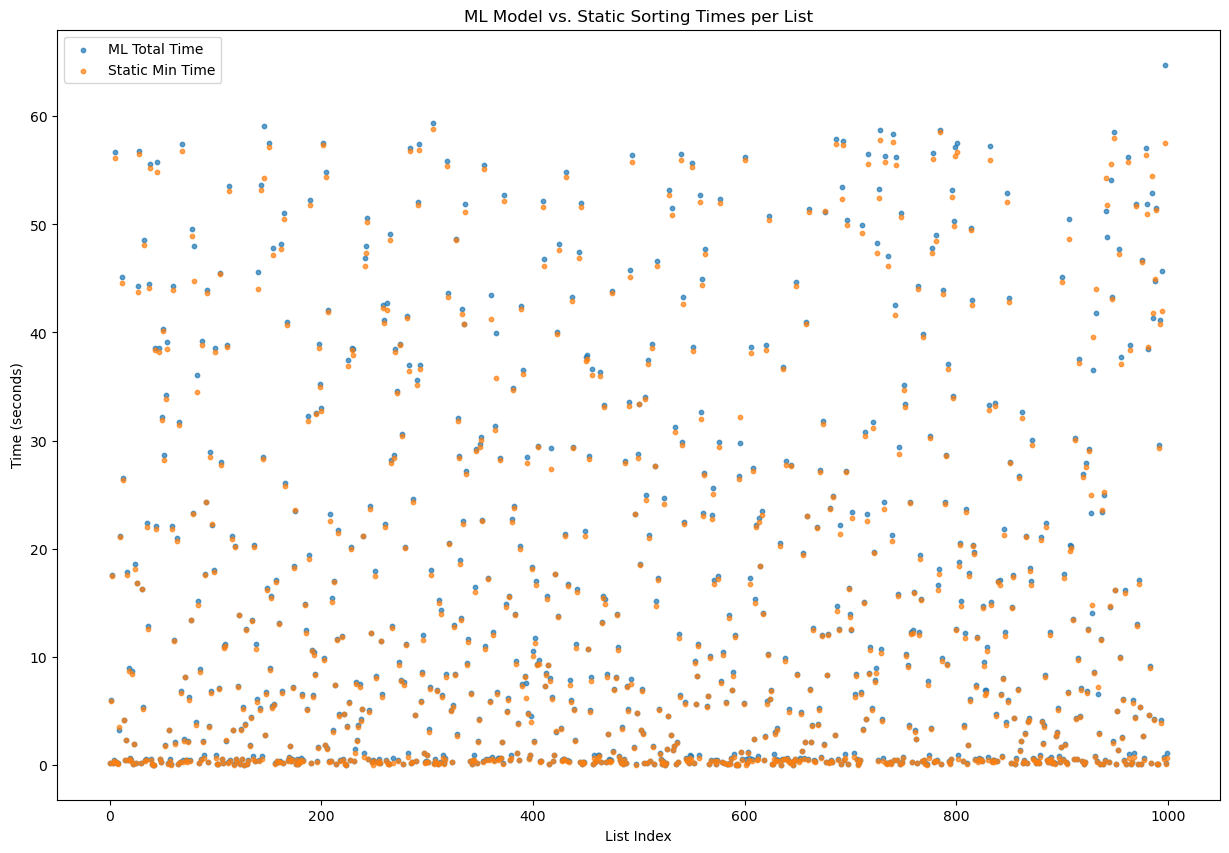

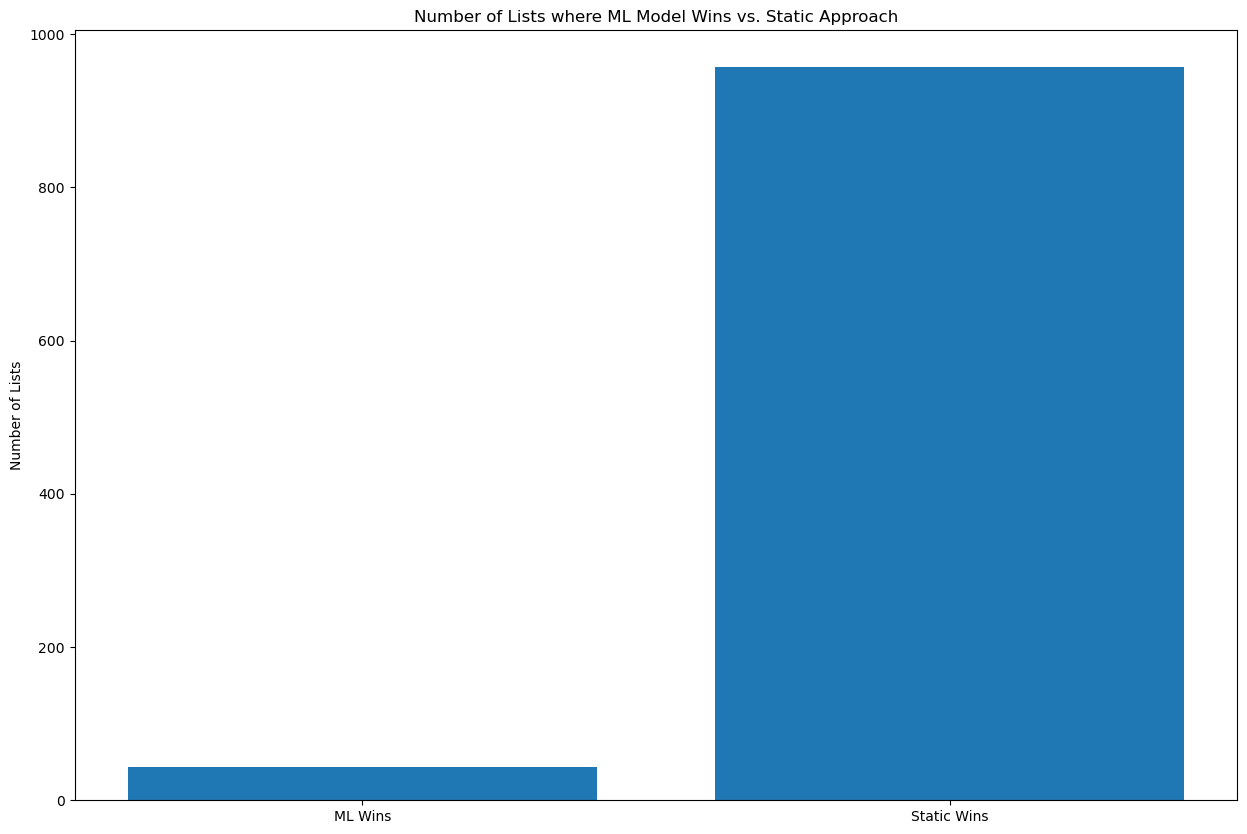

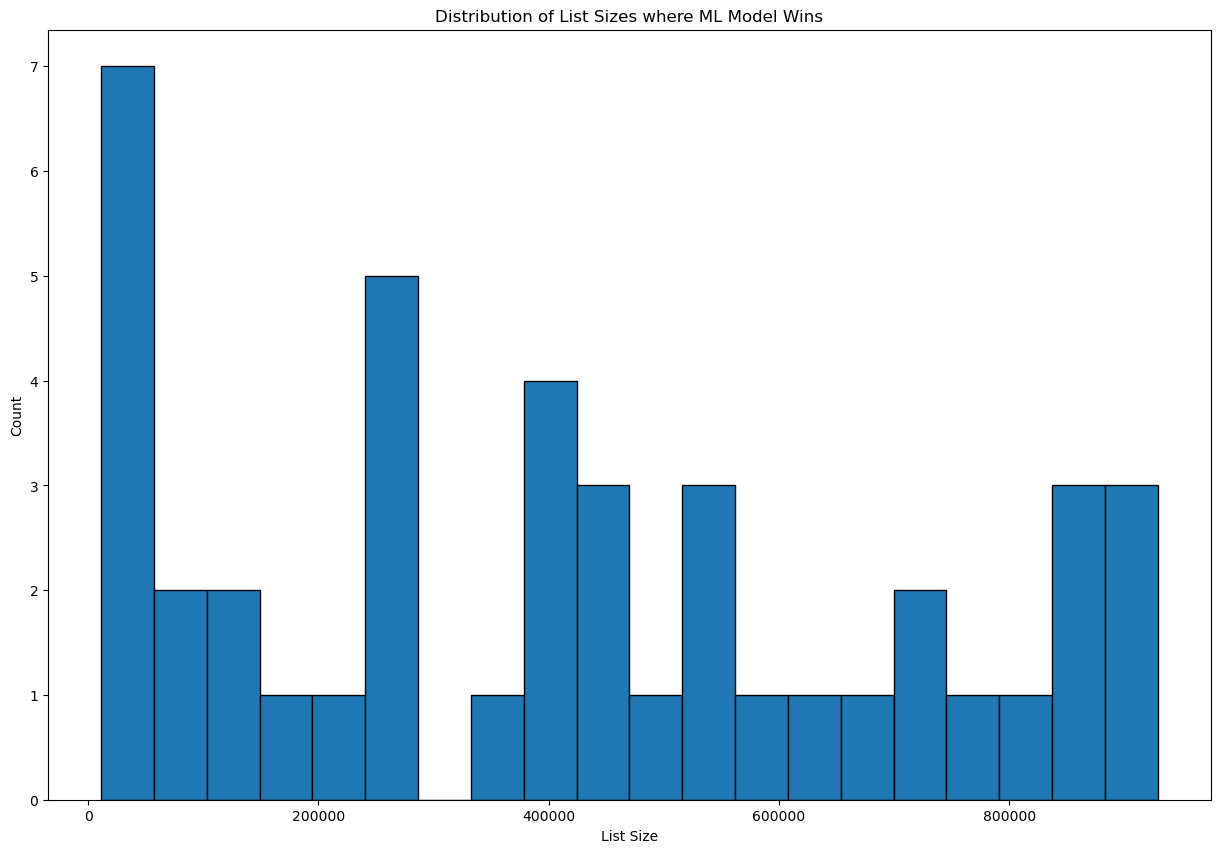

In [42]:
import warnings
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

warnings.filterwarnings("ignore")

# Filter out "insertion_sort" from the available sorters
sorters_to_test = [s for s in sorters.list_sorters() if s != "insertion_sort"]

# Collect static benchmark results with list index, sorter, and time.
static_results = []
for sorter in tqdm(sorters_to_test, desc="Benchmarking static sorters"):
    for idx, lst in enumerate(df['data']):
        result = sorters.benchmark_sorter(sorter, lst)
        static_results.append({"list_index": idx, "sorter": sorter, "time": result})

# Convert static results to a DataFrame
static_df = pd.DataFrame(static_results)

# For each list, determine the best (minimum) static sorting time.
static_min_df = static_df.groupby("list_index")["time"].min().reset_index().rename(columns={"time": "static_min_time"})

ml_results = []
for idx, lst in enumerate(tqdm(df['data'], desc="Benchmarking ML model")):
    # Measure feature extraction time
    start_extraction = time.time()
    features = rf.extract_features(lst)
    extraction_time = time.time() - start_extraction
    
    features_array = np.array(list(features.values()))
    prediction_start = time.time()
    predicted_sorter = rf_model.predict(features_array.reshape(1, -1))
    prediction_time = time.time() - prediction_start
    
    # Measure sorting time with the predicted sorter
    sorting_time = sorters.benchmark_sorter(predicted_sorter[0], lst)
    
    total_time = extraction_time + prediction_time + sorting_time
    ml_results.append({
        "list_index": idx,
        "extraction_time": extraction_time,
        "prediction_time": prediction_time,
        "sorting_time": sorting_time,
        "ml_total_time": total_time
    })

ml_df = pd.DataFrame(ml_results)

# ---- Compare ML model with the best static sorter per list ----

# Merge the ML results with the static minimum times based on list index.
comparison_df = pd.merge(ml_df, static_min_df, on="list_index")
# Create a flag: True when ML model's total time is less than the best static time.
comparison_df["ml_wins"] = comparison_df["ml_total_time"] < comparison_df["static_min_time"]

# Count wins vs. losses.
wins_count = comparison_df["ml_wins"].sum()
losses_count = len(comparison_df) - wins_count

print("Comparison DataFrame (first 10 rows):")
print(comparison_df.head(10))
print(f"\nML wins in {wins_count} out of {len(comparison_df)} lists.")
print(f"Static approach wins in {losses_count} out of {len(comparison_df)} lists.")


plt.figure(figsize=(15, 10))
plt.scatter(comparison_df["list_index"], comparison_df["ml_total_time"], label="ML Total Time", alpha=0.7, s=10)
plt.scatter(comparison_df["list_index"], comparison_df["static_min_time"], label="Static Min Time", alpha=0.7, s=10)
plt.xlabel("List Index")
plt.ylabel("Time (seconds)")
plt.title("ML Model vs. Static Sorting Times per List")
plt.legend()
plt.show()

plt.figure(figsize=(15, 10))
plt.bar(["ML Wins", "Static Wins"], [wins_count, losses_count])
plt.ylabel("Number of Lists")
plt.title("Number of Lists where ML Model Wins vs. Static Approach")
plt.show()

list_sizes = df['data'].apply(len).values
comparison_df['list_size'] = list_sizes

# Filter only the cases where the ML model wins
ml_wins_df = comparison_df[comparison_df["ml_wins"]]

# Plot a histogram of the list sizes for which the ML model wins
plt.figure(figsize=(15, 10))
plt.hist(ml_wins_df["list_size"], bins=20, edgecolor='black')
plt.xlabel("List Size")
plt.ylabel("Count")
plt.title("Distribution of List Sizes where ML Model Wins")
plt.show()


In [43]:
df2 = pd.read_feather(data_dir+"/out.feather")
df2

,data
0,[]
1,"[0, 1, 2, 3, 4, 5, 6, 13, 8, 9, 44, 11, 12, 7,..."
2,"[47, 46, 45, 10, 43, 42, 41, 40, 39, 38, 37, 3..."
3,"[0, 1, 2, 3, 4, 5, 6, 7, 33, 9, 10, 11, 12, 13..."
4,"[47, 46, 45, 44, 43, 42, 24, 21, 39, 38, 37, 3..."
...,...
33512,"[1973, 1651, 3165, 1447, 4875, 3645, 6224, 134..."
33513,"[110, 4415, 7399, 8126, 7398, 8493, 8954, 1431..."
33514,"[8514, 1847, 4781, 6522, 4676, 4711, 149, 4041..."
33515,"[3597, 5973, 1450, 2313, 3993, 5910, 1979, 407..."


Benchmarking ML model: 100%|██████████| 33517/33517 [02:52<00:00, 193.96it/s]


Comparison DataFrame (first 10 rows):
   list_index  extraction_time  prediction_time  sorting_time  ml_total_time  \
0           0         0.000982         0.008631      0.000125       0.009738   
1           1         0.000091         0.006522      0.000375       0.006988   
2           2         0.000096         0.007780      0.001500       0.009376   
3           3         0.000096         0.003884      0.000583       0.004563   
4           4         0.000074         0.004628      0.000958       0.005660   
5           5         0.000063         0.003791      0.000667       0.004521   
6           6         0.000060         0.003197      0.000959       0.004216   
7           7         0.000053         0.003675      0.000625       0.004353   
8           8         0.000056         0.003430      0.000959       0.004445   
9           9         0.000055         0.003193      0.000625       0.003873   

   static_min_time  ml_wins  
0         0.000166    False  
1         0.000250   

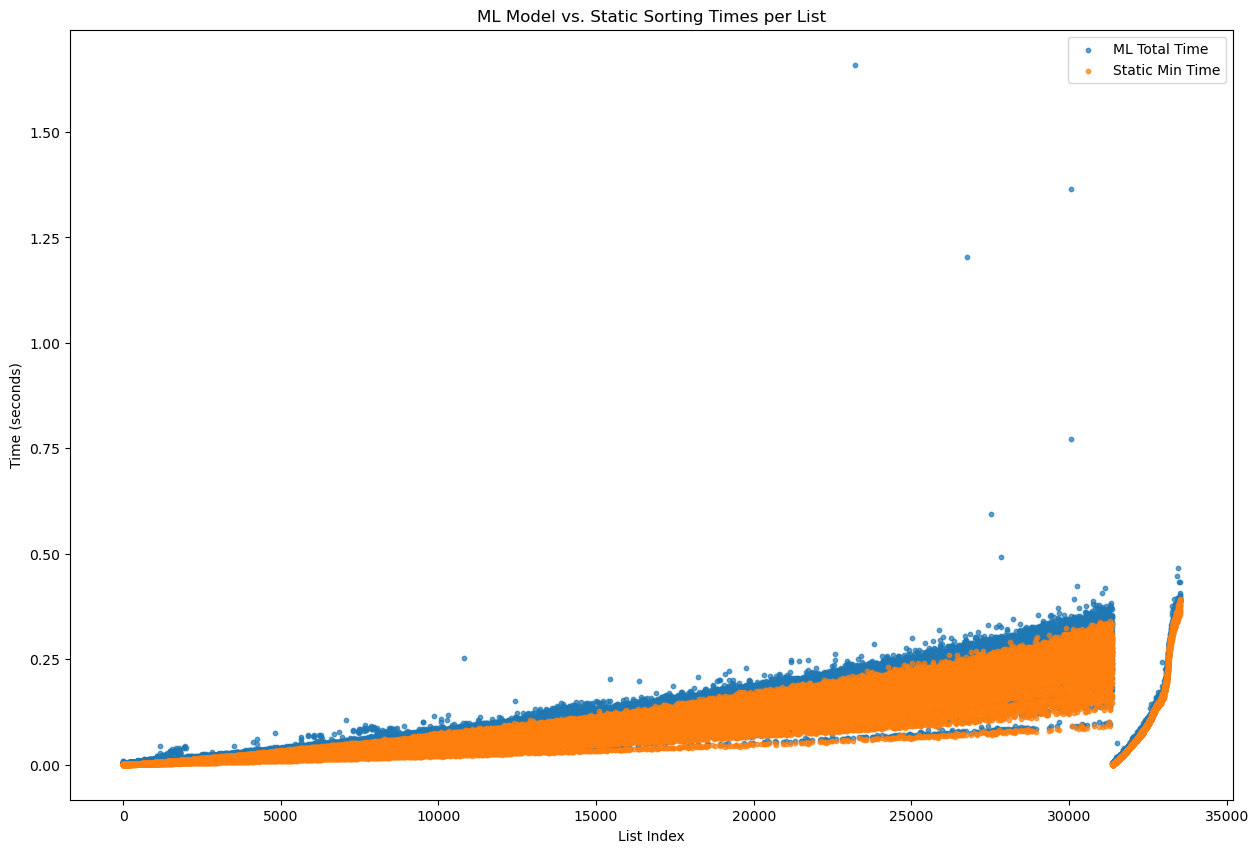

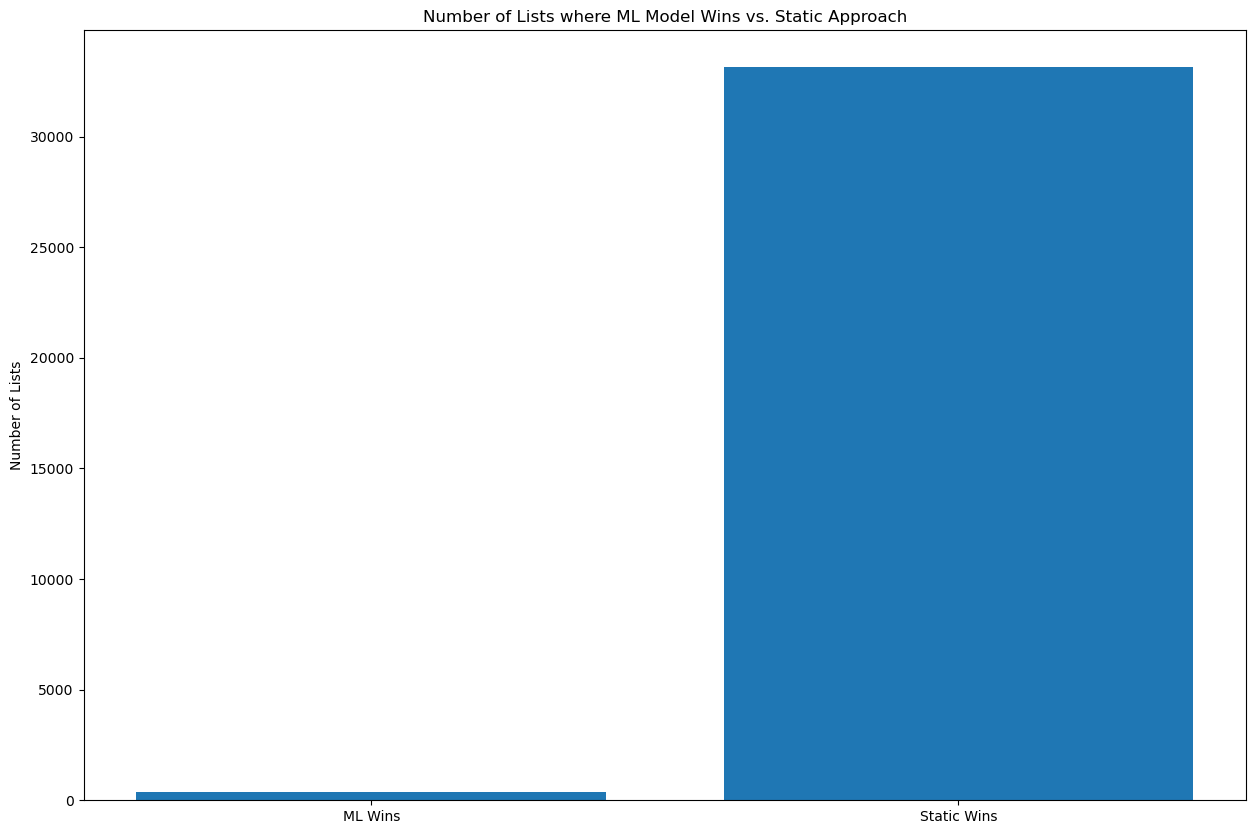

ValueError: Length of values (1000) does not match length of index (33517)

In [44]:
import warnings
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

warnings.filterwarnings("ignore")

# Filter out "insertion_sort" from the available sorters
sorters_to_test = [s for s in sorters.list_sorters() if s != "insertion_sort"]

# Collect static benchmark results with list index, sorter, and time.
static_results = []
for sorter in tqdm(sorters_to_test, desc="Benchmarking static sorters"):
    for idx, lst in enumerate(df2['data']):
        result = sorters.benchmark_sorter(sorter, lst)
        static_results.append({"list_index": idx, "sorter": sorter, "time": result})

# Convert static results to a DataFrame
static_df = pd.DataFrame(static_results)

# For each list, determine the best (minimum) static sorting time.
static_min_df = static_df.groupby("list_index")["time"].min().reset_index().rename(columns={"time": "static_min_time"})

ml_results = []
for idx, lst in enumerate(tqdm(df2['data'], desc="Benchmarking ML model")):
    # Measure feature extraction time
    start_extraction = time.time()
    features = rf.extract_features(lst)
    extraction_time = time.time() - start_extraction
    
    features_array = np.array(list(features.values()))
    prediction_start = time.time()
    predicted_sorter = rf_model.predict(features_array.reshape(1, -1))
    prediction_time = time.time() - prediction_start
    
    # Measure sorting time with the predicted sorter
    sorting_time = sorters.benchmark_sorter(predicted_sorter[0], lst)
    
    total_time = extraction_time + prediction_time + sorting_time
    ml_results.append({
        "list_index": idx,
        "extraction_time": extraction_time,
        "prediction_time": prediction_time,
        "sorting_time": sorting_time,
        "ml_total_time": total_time
    })

ml_df = pd.DataFrame(ml_results)

# ---- Compare ML model with the best static sorter per list ----

# Merge the ML results with the static minimum times based on list index.
comparison_df = pd.merge(ml_df, static_min_df, on="list_index")
# Create a flag: True when ML model's total time is less than the best static time.
comparison_df["ml_wins"] = comparison_df["ml_total_time"] < comparison_df["static_min_time"]

# Count wins vs. losses.
wins_count = comparison_df["ml_wins"].sum()
losses_count = len(comparison_df) - wins_count

print("Comparison DataFrame (first 10 rows):")
print(comparison_df.head(10))
print(f"\nML wins in {wins_count} out of {len(comparison_df)} lists.")
print(f"Static approach wins in {losses_count} out of {len(comparison_df)} lists.")


plt.figure(figsize=(15, 10))
plt.scatter(comparison_df["list_index"], comparison_df["ml_total_time"], label="ML Total Time", alpha=0.7, s=10)
plt.scatter(comparison_df["list_index"], comparison_df["static_min_time"], label="Static Min Time", alpha=0.7, s=10)
plt.xlabel("List Index")
plt.ylabel("Time (seconds)")
plt.title("ML Model vs. Static Sorting Times per List")
plt.legend()
plt.show()

plt.figure(figsize=(15, 10))
plt.bar(["ML Wins", "Static Wins"], [wins_count, losses_count])
plt.ylabel("Number of Lists")
plt.title("Number of Lists where ML Model Wins vs. Static Approach")
plt.show()

list_sizes = df['data'].apply(len).values
comparison_df['list_size'] = list_sizes

# Filter only the cases where the ML model wins
ml_wins_df = comparison_df[comparison_df["ml_wins"]]

# Plot a histogram of the list sizes for which the ML model wins
plt.figure(figsize=(15, 10))
plt.hist(ml_wins_df["list_size"], bins=20, edgecolor='black')
plt.xlabel("List Size")
plt.ylabel("Count")
plt.title("Distribution of List Sizes where ML Model Wins")
plt.show()
